# Taxi Data 
Data on taxi trips in NYC for the month of June 2019. <br>
Data available at: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [1]:
## -- Packages  -- ##

# General
import pandas as pd
import numpy as np
import os

# Time formatting
import datetime

# Load and save data
import pickle

# Download multiple files
import glob

# Plotting
from matplotlib import pyplot as plt

# Stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL  # requires statsmodels version 11

In [2]:
## Can not install via anaconda interface so use pip install
#!pip install statsmodels --upgrade

## check version of statsmodels. Should be '0.11.0'
import statsmodels
statsmodels.__version__

'0.11.1'

In [3]:
## load data
path = "/Users/conorcavanaugh/Data/speciale/traffic_data/1 year/"

all_files = glob.glob(os.path.join(path, "*.csv"))

df_from_each_file = (pd.read_csv(f) for f in all_files)
concatenated_df   = pd.concat(df_from_each_file, ignore_index=True, sort = False)

In [4]:
concatenated_df.shape

(93337651, 18)

In [5]:
## Feature selection and generation
features = ['tpep_pickup_datetime','tpep_dropoff_datetime']
df = concatenated_df.loc[:,features]

df['tpep_pickup_datetime'] =  pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] =  pd.to_datetime(df['tpep_dropoff_datetime'])

#df['trip_time'] = df.loc[:,'tpep_dropoff_datetime'] - df.loc[:,'tpep_pickup_datetime']

In [6]:
df.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
dtype: object

In [7]:
df.shape

(93337651, 2)

In [11]:
## Create timeseries of taxi demand without features, initially in intervals of 1 hour
index = pd.DatetimeIndex(df.loc[:,'tpep_pickup_datetime'])
series = pd.Series(0, index=index)

## Split into hourly intervals by count
frequency = 'H'
taxidemand_ts = series.resample(rule = frequency).count()

## remove all dates not in the specific date range, ending up with a full year of data, ending in june 2019
taxidemand_ts = taxidemand_ts["2018-07" : "2019-06"]

In [12]:
## Check if all 12 months are in the data
taxidemand_ts.index.month.unique()

Int64Index([7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6], dtype='int64', name='tpep_pickup_datetime')

In [26]:
## Check if any dates are duplicated
taxidemand_ts.index.duplicated().sum()

0

/Users/conorcavanaugh/Applications/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


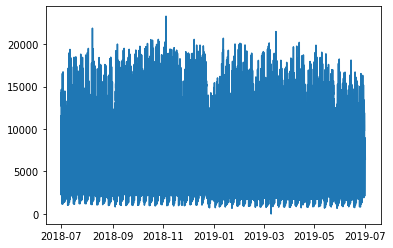

In [13]:
plt.plot(taxidemand_ts)

In [14]:
## check for outliers
taxidemand_ts.loc[taxidemand_ts < 500]
## The observation of 0 taxi trips must be an outlier since there is no other observation even close to 0. This
##is actually the hour of daylight savings, which should be removed.

tpep_pickup_datetime
2019-03-10 02:00:00    0
Freq: H, dtype: int64

In [15]:
## fill in the outlier with the last seasonal value
taxidemand_ts["2019-03-10 02:00:00"] = taxidemand_ts["2019-03-03 02:00:00"]

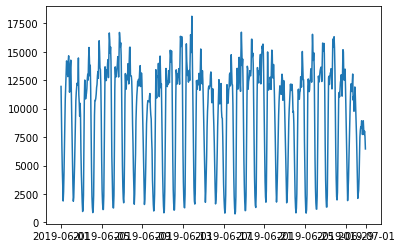

In [17]:
## Plot the last month of the data
plt.plot(taxidemand_ts["2019-06"])
## Looks like the last day should be removed

In [24]:
##Save preproccesed dataframe to be used in other notebooks
#outfile = open('taxi_data_df','wb')
#pickle.dump(df,outfile)
#outfile.close()

##Save preproccesed time series to be used in other notebooks
#outfile = open('taxi_series_' + frequency,'wb')
#pickle.dump(taxidemand_ts,outfile)
#outfile.close()

## Save csv file of preproccesed series
#taxidemand_ts.to_csv("taxi_series_hourly.csv", header = True)

In [18]:
## ADF test of taxidemand
X = taxidemand_ts.values
result = adfuller(X)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.088812
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [19]:
#Make seasonal difference of 1 hours
taxidiff = taxidemand_ts - taxidemand_ts.shift(1)
taxidiff = taxidiff.iloc[1:len(taxidemand_ts)]

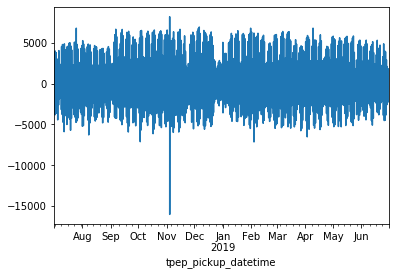

In [20]:
#Plot time series
taxidiff.plot()
plt.show()

In [21]:
#ADF test for stationarity
taxidiff.dropna(inplace = True)
X = taxidiff.values
result = adfuller(X)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -21.077645
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


### Seasonal decomposition

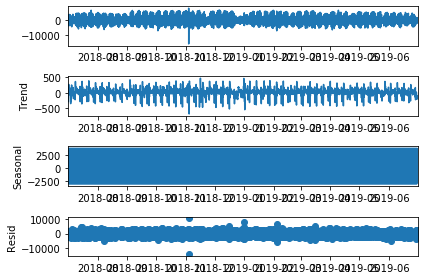

In [22]:
result = seasonal_decompose(taxidiff, model='additive')
result.plot()
plt.show()

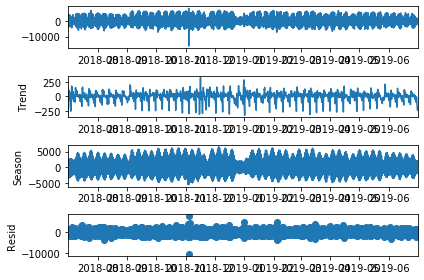

In [23]:
result = STL(taxidiff).fit()
result.plot()
plt.show()

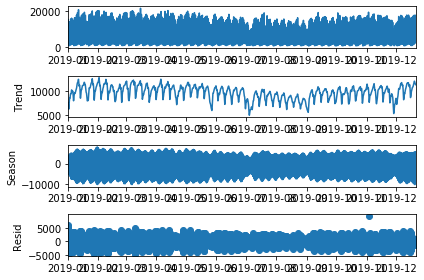

In [179]:
result = STL(taxidemand_ts).fit()
result.plot()
plt.show()

In [34]:
train = taxidemand_ts[0:-24*9]
test = taxidemand_ts[-24*9:-24*8]

In [37]:
pip install tbats

     |████████████████████████████████| 51kB 1.7MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [38]:
from tbats import TBATS

estimator = TBATS(seasonal_periods = [24,168])

fit = estimator.fit(train)

fc = fit.forecast(steps = 24)

In [39]:
fc

array([ 9705.15290727,  6727.17929127,  4288.54326562,  2661.1405689 ,
        2098.21774955,  2473.03702028,  5072.16954504,  8077.69028141,
        9841.20183328, 10224.6638984 , 10206.68330884, 10693.38992734,
       11223.64843466, 11528.93895823, 12158.549831  , 12488.75563203,
       11838.71778944, 13827.23780072, 15579.47044252, 15320.84535508,
       14280.63594712, 14597.9378408 , 13953.77325979, 11449.25104936])

In [42]:
from tbats import BATS